In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Describes how to read the PDO time series from JISAO.  Data are read from http://research.jisao.washington.edu/pdo/PDO.latest.txt into a pandas dataframe.

In [2]:
import pandas as pd
import xarray as xr

import re
import glob
import os

In [34]:
PDOURL = 'http://jisao.washington.edu/pdo/PDO.latest.txt'
#PDOURL = '/projects/arctic_scientist_data/Climate_Indices/PDO/PDO.latest'

In [35]:
def read_pdo():
    
    df = pd.read_csv(PDOURL, sep='\s+', skiprows=32, skipfooter=20, index_col=0, 
                 header=0, engine='python')
    # later years have ** appended to indicate values from OISSTv2 - remove these
    p = re.compile('\*\*!')
    df.index = [idx if p.search(idx) else idx[0:4] for idx in df.index]
    
    # Stack year and moonths as multiIndex dataFrame
    df_new = df.stack()
    
    # Generate new datetime index
    datestr = ['{:s} {:s}'.format(y, m) for y, m in zip(df_new.index.get_level_values(0), 
                                                        df_new.index.get_level_values(1))]
    df_new.index = pd.to_datetime( datestr, format='%Y %b' )
    
    return df_new


In [5]:
pdo = read_pdo()
pdo = pdo['1980':]
pdo.head()

1980-01-01   -0.11
1980-02-01    1.32
1980-03-01    1.09
1980-04-01    1.49
1980-05-01    1.20
dtype: float64

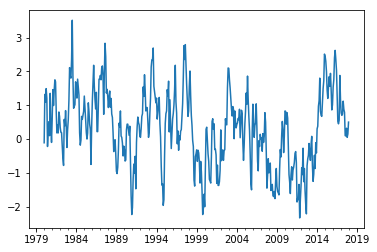

In [6]:
pdo.plot()

In [22]:
n = pdo.size
idx = np.int(n*0.1) # Find index for 10%
print (idx)
negative_dates = xr.DataArray(pdo.sort_values()[0:idx].index.values)
negative_dates

45


<xarray.DataArray (dim_0: 45)>
array(['2011-11-01T00:00:00.000000000', '1999-10-01T00:00:00.000000000',
       '1990-12-01T00:00:00.000000000', '2012-09-01T00:00:00.000000000',
       '1999-11-01T00:00:00.000000000', '1991-01-01T00:00:00.000000000',
       '2000-01-01T00:00:00.000000000', '1994-11-01T00:00:00.000000000',
       '2012-08-01T00:00:00.000000000', '2011-07-01T00:00:00.000000000',
       '2011-09-01T00:00:00.000000000', '1994-12-01T00:00:00.000000000',
       '2011-12-01T00:00:00.000000000', '2008-10-01T00:00:00.000000000',
       '2011-08-01T00:00:00.000000000', '2008-08-01T00:00:00.000000000',
       '1990-11-01T00:00:00.000000000', '2008-07-01T00:00:00.000000000',
       '2009-04-01T00:00:00.000000000', '1999-12-01T00:00:00.000000000',
       '2010-09-01T00:00:00.000000000', '2009-03-01T00:00:00.000000000',
       '2008-09-01T00:00:00.000000000', '2009-02-01T00:00:00.000000000',
       '1999-09-01T00:00:00.000000000', '2012-07-01T00:00:00.000000000',
       '2008-04-01T0

In [23]:
positive_dates = xr.DataArray( pdo.sort_values(ascending=False)[0:idx].index.values )
positive_dates

<xarray.DataArray (dim_0: 45)>
array(['1983-07-01T00:00:00.000000000', '1987-08-01T00:00:00.000000000',
       '1997-08-01T00:00:00.000000000', '1997-06-01T00:00:00.000000000',
       '1993-08-01T00:00:00.000000000', '2016-04-01T00:00:00.000000000',
       '2014-12-01T00:00:00.000000000', '2015-01-01T00:00:00.000000000',
       '1987-09-01T00:00:00.000000000', '2016-03-01T00:00:00.000000000',
       '1983-06-01T00:00:00.000000000', '2016-05-01T00:00:00.000000000',
       '1993-07-01T00:00:00.000000000', '1997-07-01T00:00:00.000000000',
       '1993-06-01T00:00:00.000000000', '2015-02-01T00:00:00.000000000',
       '1997-09-01T00:00:00.000000000', '1986-03-01T00:00:00.000000000',
       '1996-05-01T00:00:00.000000000', '1987-04-01T00:00:00.000000000',
       '1993-05-01T00:00:00.000000000', '1983-03-01T00:00:00.000000000',
       '1987-03-01T00:00:00.000000000', '2002-12-01T00:00:00.000000000',
       '2003-01-01T00:00:00.000000000', '2016-06-01T00:00:00.000000000',
       '1987-07-01T0

Get OISSTv2 data

In [24]:
def get_oisst():
    
    SSTPATH = '/projects/arctic_scientist_data/NOAA_OISSTv2/sst/monthly'
    fileList = glob.glob( os.path.join( SSTPATH, 'sst.month.mean.????.v2.nc') )
    fileList.sort()
    #return fileList

    ds = xr.open_mfdataset(fileList, concat_dim='time')
    da = ds['sst'].load()
    ds.close()
    
    return da

def monAnom(x, year_begin='1981', year_end='2010'):
    """
    Calculates anomalies of x relative to the 1981-2010 period.

    N.B. Ideally, I would like to use an arbitrary mean field
    """
                                     
    def _anom(x):
        return x - x.sel(time=slice(year_begin,year_end)).mean(dim='time')

    return x.groupby('time.month').apply(_anom)


In [25]:
sst = get_oisst()

In [26]:
sstAnom = monAnom(sst)

In [27]:
sstAnom_neg = sstAnom.sel(time=negative_dates, method='nearest').mean(dim='dim_0')
sstAnom_neg

<xarray.DataArray 'sst' (lat: 720, lon: 1440)>
array([[      nan,       nan,       nan, ...,       nan,       nan,       nan],
       [      nan,       nan,       nan, ...,       nan,       nan,       nan],
       [      nan,       nan,       nan, ...,       nan,       nan,       nan],
       ...,
       [-0.032912, -0.03289 , -0.032892, ..., -0.032904, -0.032899, -0.032914],
       [-0.032161, -0.032134, -0.032155, ..., -0.032142, -0.032145, -0.032145],
       [-0.031727, -0.031727, -0.031724, ..., -0.03172 , -0.031723, -0.031724]],
      dtype=float32)
Coordinates:
  * lat      (lat) float32 -89.875 -89.625 -89.375 -89.125 -88.875 -88.625 ...
  * lon      (lon) float32 0.125 0.375 0.625 0.875 1.125 1.375 1.625 1.875 ...

In [28]:
sstAnom_pos = sstAnom.sel(time=positive_dates, method='nearest').mean(dim='dim_0')

In [32]:
def plot_sst_anomaly(sstAnom, loc, map_proj, extent, title='SST', add_colorbar=True, vmin=-2, vmax=2):
    """
    Plots SST anomaly
    """
    ax = plt.subplot( loc, projection=map_proj )
    ax.set_extent( extent, ccrs.PlateCarree())
    if add_colorbar:
        cax = sstAnom.sel(lat=slice(30,90), lon=slice(90,270)).plot(ax=ax,
                                                                 transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, 
                                                                 cmap='coolwarm', 
                                                                 cbar_kwargs={'orientation': 'horizontal',
                                                                              'label': 'K'})
        cax.colorbar.set_label('K', size=20)
    else:
        cax = sstAnom.sel(lat=slice(30,90), lon=slice(90,270)).plot(ax=ax,
                                                                 transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, 
                                                                 cmap='coolwarm', 
                                                                 add_colorbar=False)
        
    ax.add_feature( cfeature.LAND )
    ax.gridlines( xlocs=[0,150,180,210,359], ylocs=[40,60,80], linestyles='dotted')
    ax.set_title(title, fontsize=20);
    ax.plot(-168.968, 66.338, 'yo', transform=ccrs.PlateCarree(), ms=7, markeredgecolor='k') # Location of A3

    return ax, cax

In [30]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

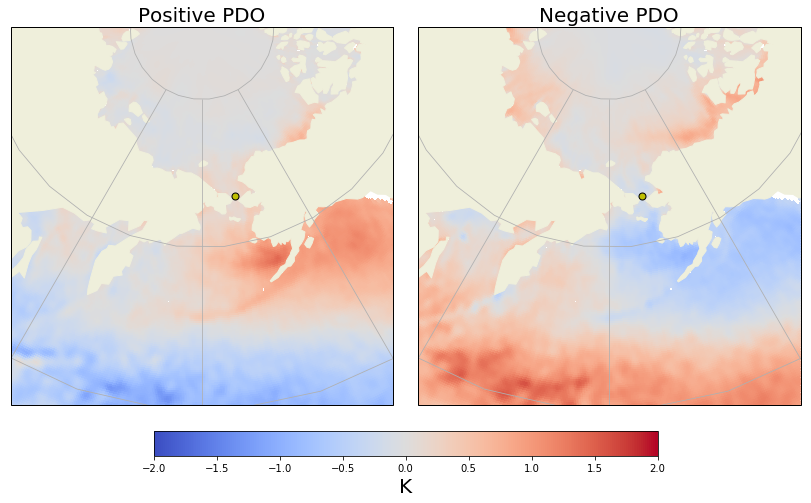

In [33]:
fig = plt.figure(figsize=(14, 7))
    
# Set up map projection and extent
map_proj = ccrs.NorthPolarStereo(central_longitude=180.)
extent = [150.,210.,40.,90.]
    
ax = []

ax1, im1 = plot_sst_anomaly(sstAnom_pos, 121, map_proj, extent, title='Positive PDO', add_colorbar=False)
ax.append( ax1 )
ax2, im2 = plot_sst_anomaly(sstAnom_neg, 122, map_proj, extent, title='Negative PDO', add_colorbar=False)
ax.append( ax2 )

fig.subplots_adjust(bottom=0.15, top=0.9, left=0.1, right=0.9,
                    wspace=0.02, hspace=0.02)
cb_ax = fig.add_axes([0.25, 0.05, 0.5, 0.05])
cbar = fig.colorbar(im1, cax=cb_ax, orientation='horizontal')
cbar.set_label('K', fontsize=20)

fig.savefig('pdo_phases_top10.png')